<a href="https://colab.research.google.com/github/LangAbhinav/docs/blob/main/songnew1ofnew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
import zipfile
file_path = '/content/drive/MyDrive/dataset/song/song.zip'
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall()



In [3]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import string
import numpy as np


In [4]:
import nltk
import string
def tokenize_new(new, num_words=-1):
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(new)
  return tokenizer

def create_lyrics_new(df, text):
  # Remove all other punctuation
  df[text] = df[text].str.replace('[{}]'.format(string.punctuation), '')
  # Make it lowercase
  df[text] = df[text].str.lower()
  # Make it one long string to split by line
  lyrics = df[text].str.cat()
  new = lyrics.split('\n')
  # Remove any trailing whitespace
  for l in range(len(new)):
    new[l] = new[l].rstrip()
  # Remove any empty lines
  new = [l for l in new if l != '']

  return new


In [5]:
df = pd.read_csv(file_path, encoding="ISO-8859-1", dtype=str)[:10]
new = create_lyrics_new(df, 'lyric')
# Tokenize the corpus
tokenizer = tokenize_new(new)

total_words = len(tokenizer.word_index) + 1
print(tokenizer.word_index)
print(total_words)

{'a': 1, 'said': 2, 'the': 3, 'my': 4, 'to': 5, 'that': 6, 'summer': 7, 'you': 8, 'think': 9, 'he': 10, 'way': 11, 'blue': 12, 'eyes': 13, 'shinedput': 14, 'those': 15, 'georgia': 16, 'stars': 17, 'shame': 18, 'nighti': 19, 'thats': 20, 'liejust': 21, 'boy': 22, 'in': 23, 'chevy': 24, 'truckthat': 25, 'had': 26, 'tendency': 27, 'of': 28, 'gettin': 29, 'stuckon': 30, 'backroads': 31, 'at': 32, 'nightand': 33, 'i': 34, 'was': 35, 'right': 36, 'there': 37, 'beside': 38, 'him': 39, 'all': 40, 'longand': 41, 'then': 42, 'time': 43, 'we': 44, 'woke': 45, 'up': 46, 'find': 47, 'gonebut': 48, 'when': 49, 'tim': 50, 'mcgrawi': 51, 'hope': 52, 'favorite': 53, 'song': 54}
55


<ipython-input-4-f5af19287d58>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df[text] = df[text].str.replace('[{}]'.format(string.punctuation), '')


In [6]:
sequences = []
for line in new:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		sequences.append(n_gram_sequence)

# Pad sequences for equal input length
max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))

# Split sequences between the "input" sequence and "output" predicted word
input_sequences, labels = sequences[:,:-1], sequences[:,-1]
# One-hot encode the labels
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#history = model.fit(input_sequences, one_hot_labels, epochs=500, verbose=1)
history = model.fit(input_sequences, one_hot_labels, epochs=200, batch_size=2, verbose=1)


Epoch 1/200
32/32 [==============================] - 7s 106ms/step - loss: 4.0233 - accuracy: 0.0000e+00
Epoch 2/200
32/32 [==============================] - 1s 33ms/step - loss: 3.9873 - accuracy: 0.0625
Epoch 3/200
32/32 [==============================] - 1s 31ms/step - loss: 3.9355 - accuracy: 0.0781
Epoch 4/200
32/32 [==============================] - 1s 31ms/step - loss: 3.7533 - accuracy: 0.1094
Epoch 5/200
32/32 [==============================] - 1s 27ms/step - loss: 3.4562 - accuracy: 0.1094
Epoch 6/200
32/32 [==============================] - 0s 11ms/step - loss: 3.2244 - accuracy: 0.0938
Epoch 7/200
32/32 [==============================] - 1s 23ms/step - loss: 3.0138 - accuracy: 0.1406
Epoch 8/200
32/32 [==============================] - 0s 8ms/step - loss: 2.8444 - accuracy: 0.1562
Epoch 9/200
32/32 [==============================] - 0s 11ms/step - loss: 2.6843 - accuracy: 0.1250
Epoch 10/200
32/32 [==============================] - 0s 12ms/step - loss: 2.5980 - accuracy: 0.

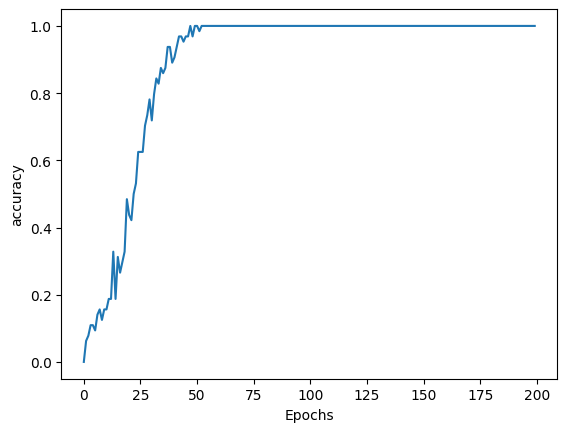

In [26]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

In [27]:
# Evaluate the model on the training data
train_loss, train_accuracy = model.evaluate(input_sequences, one_hot_labels, verbose=1)

# Print the training accuracy
print("Training Accuracy:", train_accuracy)


2/2 [==============================] - 1s 11ms/step - loss: 0.0068 - accuracy: 1.0000
Training Accuracy: 1.0


In [28]:
seed_text = "i am in love baby"
next_words = 100

generated_text = seed_text
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = np.argmax(model.predict(token_list), axis=-1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
    generated_text += " " + output_word

# Print the generated text
print(generated_text)


1/1 [==============================] - 0s 19ms/step
i am in love baby said the way my blue eyes shinedput those georgia stars to shame that nighti said thats a liejust a boy in a chevy truckthat had a tendency of gettin stuckon backroads at nightand i was right there beside him all summer longand then the time we woke up to find that summer gonebut when you think tim mcgrawi hope you think my favorite song favorite song song song song song song song song song summer gonebut when you think tim mcgrawi summer gonebut when you think my think my favorite hope you favorite song song song song song favorite song
